# Train and Evaluate Mask R-CNN on visible masks

To solely train Mask R-CNN on visible masks, you first need to comment out the lines that involve the loading of the additional masks in the file detectron2/data/detection_utils.py:
comment out these lines: 298, 303, 307, 314, 326-328, 332

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()
    
# run on gpu 0 (NVIDIA Geforce GTX 1080Ti) and gpu 1 (NVIDIA Geforce GTX 1070Ti)
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

## Register the visible datasets 

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("broccoli_visible_train", {}, "datasets/train_val_test_files/mrcnn/mrcnn_only_visible/train/annotations.json", "datasets/train_val_test_files/mrcnn/mrcnn_only_visible/train")
register_coco_instances("broccoli_visible_val", {}, "datasets/train_val_test_files/mrcnn/mrcnn_only_visible/val/annotations.json", "datasets/train_val_test_files/mrcnn/mrcnn_only_visible/val")
register_coco_instances("broccoli_visible_test", {}, "datasets/train_val_test_files/mrcnn/mrcnn_only_visible/test/annotations.json", "datasets/train_val_test_files/mrcnn/mrcnn_only_visible/test")

In [3]:
broccoli_visible_train_metadata = MetadataCatalog.get("broccoli_visible_train")
print(broccoli_visible_train_metadata)

broccoli_visible_val_metadata = MetadataCatalog.get("broccoli_visible_val")
print(broccoli_visible_val_metadata)

broccoli_visible_test_metadata = MetadataCatalog.get("broccoli_visible_test")
print(broccoli_visible_test_metadata)

Metadata(evaluator_type='coco', image_root='datasets/train_val_test_files/mrcnn/mrcnn_only_visible/train', json_file='datasets/train_val_test_files/mrcnn/mrcnn_only_visible/train/annotations.json', name='broccoli_visible_train')
Metadata(evaluator_type='coco', image_root='datasets/train_val_test_files/mrcnn/mrcnn_only_visible/val', json_file='datasets/train_val_test_files/mrcnn/mrcnn_only_visible/val/annotations.json', name='broccoli_visible_val')
Metadata(evaluator_type='coco', image_root='datasets/train_val_test_files/mrcnn/mrcnn_only_visible/test', json_file='datasets/train_val_test_files/mrcnn/mrcnn_only_visible/test/annotations.json', name='broccoli_visible_test')


In [4]:
dataset_dicts_train = DatasetCatalog.get("broccoli_visible_train")
dataset_dicts_val = DatasetCatalog.get("broccoli_visible_val")
dataset_dicts_test = DatasetCatalog.get("broccoli_visible_test")

[10/10 11:15:53 d2.data.datasets.coco]: Loaded 1569 images in COCO format from datasets/train_val_test_files/mrcnn/mrcnn_only_visible/train/annotations.json
[10/10 11:15:53 d2.data.datasets.coco]: Loaded 504 images in COCO format from datasets/train_val_test_files/mrcnn/mrcnn_only_visible/val/annotations.json
[10/10 11:15:53 d2.data.datasets.coco]: Loaded 487 images in COCO format from datasets/train_val_test_files/mrcnn/mrcnn_only_visible/test/annotations.json


## Visualize the visible masks 

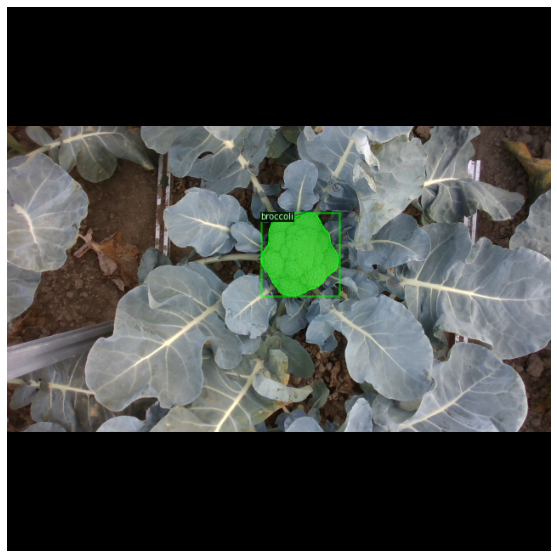

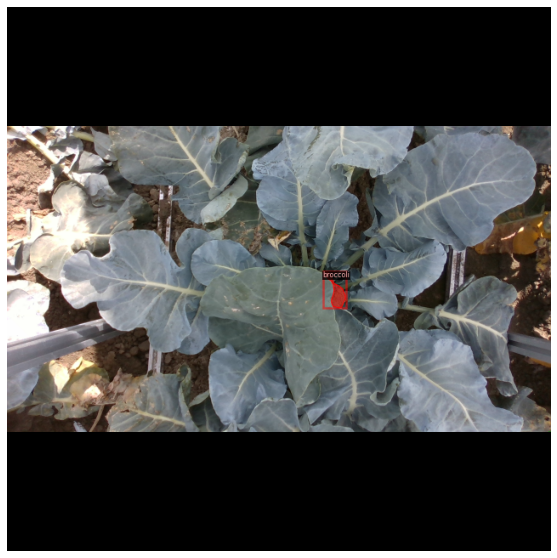

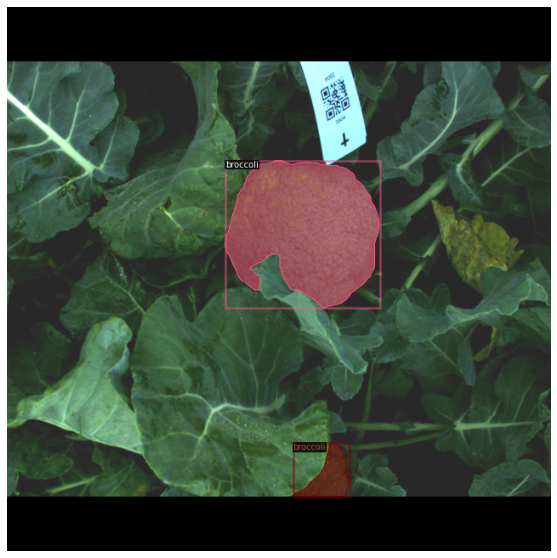

In [5]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_visible_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d, segm='segmentation')
    imshow(vis.get_image()[:, :, ::-1])

## Initialize the training and inference parameters

In [6]:
# thanks to: https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# thanks to: https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=B4UESNQ4tyVm
# code extracted from: https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [7]:
from detectron2.evaluation import COCOEvaluator

class VisibleTrainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            20,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [8]:
import os
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("broccoli_visible_train",)
cfg.DATASETS.TEST = ("broccoli_visible_val",)

cfg.NUM_GPUS = 2
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

# solver file settings extracted from: https://github.com/facebookresearch/Detectron/blob/master/configs/04_2018_gn_baselines/scratch_e2e_mask_rcnn_R-101-FPN_3x_gn.yaml
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 15000
cfg.SOLVER.STEPS = (0, 7000, 11000)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (broccoli)

# https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.OUTPUT_DIR = "weights/20201010_broccoli_visible"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = VisibleTrainer(cfg) 

[10/10 11:16:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/10 11:16:11 d2.data.datasets.coco]: Loaded 1569 images in COCO format from datasets/train_val_test_files/mrcnn/mrcnn_only_visible/train/annotations.json
[10/10 11:16:11 d2.data.build]: Removed 0 images with no usable annotations. 1569 images left.
[10/10 11:16:11 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  broccoli  | 2198         |
|            |              |
[10/10 11:16:11 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/10 11:16:11 d2.data.build]: Using training sampler TrainingSampler
[10/10 11:16:11 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/10 11:16:11 d2.data.datasets.coco]: Loaded 504 images in COCO format from dat

## Start the training 

In [9]:
trainer.resume_or_load(resume=False)
trainer.train()

[10/10 11:16:11 d2.engine.train_loop]: Starting training from iteration 0
[10/10 11:17:24 d2.utils.events]: eta: 2:38:27  iter: 19  total_loss: 1.771  loss_cls: 0.858  loss_box_reg: 0.140  loss_mask: 0.684  loss_rpn_cls: 0.021  loss_rpn_loc: 0.004  validation_loss: 1.323  time: 0.6379  data_time: 0.0086  lr: 0.000040  max_mem: 4250M
[10/10 11:18:35 d2.utils.events]: eta: 2:37:35  iter: 39  total_loss: 1.072  loss_cls: 0.259  loss_box_reg: 0.190  loss_mask: 0.566  loss_rpn_cls: 0.017  loss_rpn_loc: 0.004  validation_loss: 1.085  time: 0.6325  data_time: 0.0026  lr: 0.000080  max_mem: 4250M
[10/10 11:19:48 d2.utils.events]: eta: 2:38:02  iter: 59  total_loss: 0.670  loss_cls: 0.126  loss_box_reg: 0.143  loss_mask: 0.395  loss_rpn_cls: 0.006  loss_rpn_loc: 0.003  validation_loss: 0.846  time: 0.6345  data_time: 0.0024  lr: 0.000120  max_mem: 4250M
[10/10 11:21:01 d2.utils.events]: eta: 2:36:49  iter: 79  total_loss: 0.686  loss_cls: 0.141  loss_box_reg: 0.200  loss_mask: 0.252  loss_rpn_c

[10/10 11:53:19 d2.utils.events]: eta: 2:30:42  iter: 619  total_loss: 0.179  loss_cls: 0.032  loss_box_reg: 0.045  loss_mask: 0.083  loss_rpn_cls: 0.003  loss_rpn_loc: 0.002  validation_loss: 0.200  time: 0.6233  data_time: 0.0023  lr: 0.001239  max_mem: 4363M
[10/10 11:54:32 d2.utils.events]: eta: 2:30:31  iter: 639  total_loss: 0.158  loss_cls: 0.025  loss_box_reg: 0.051  loss_mask: 0.075  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  validation_loss: 0.198  time: 0.6235  data_time: 0.0024  lr: 0.001279  max_mem: 4363M
[10/10 11:55:45 d2.utils.events]: eta: 2:30:26  iter: 659  total_loss: 0.206  loss_cls: 0.040  loss_box_reg: 0.062  loss_mask: 0.082  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  validation_loss: 0.197  time: 0.6241  data_time: 0.0024  lr: 0.001319  max_mem: 4363M
[10/10 11:56:57 d2.utils.events]: eta: 2:30:27  iter: 679  total_loss: 0.143  loss_cls: 0.026  loss_box_reg: 0.041  loss_mask: 0.065  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.196  time: 0.6250  

[10/10 12:30:52 d2.utils.events]: eta: 2:25:52  iter: 1239  total_loss: 0.162  loss_cls: 0.026  loss_box_reg: 0.053  loss_mask: 0.067  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.182  time: 0.6285  data_time: 0.0025  lr: 0.002000  max_mem: 4423M
[10/10 12:32:05 d2.utils.events]: eta: 2:25:42  iter: 1259  total_loss: 0.160  loss_cls: 0.027  loss_box_reg: 0.055  loss_mask: 0.082  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.181  time: 0.6288  data_time: 0.0024  lr: 0.002000  max_mem: 4423M
[10/10 12:33:18 d2.utils.events]: eta: 2:25:40  iter: 1279  total_loss: 0.155  loss_cls: 0.024  loss_box_reg: 0.053  loss_mask: 0.066  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.181  time: 0.6289  data_time: 0.0028  lr: 0.002000  max_mem: 4423M
[10/10 12:34:31 d2.utils.events]: eta: 2:25:31  iter: 1299  total_loss: 0.195  loss_cls: 0.027  loss_box_reg: 0.060  loss_mask: 0.085  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.179  time: 0.62

[10/10 13:08:26 d2.utils.events]: eta: 2:19:18  iter: 1859  total_loss: 0.136  loss_cls: 0.021  loss_box_reg: 0.049  loss_mask: 0.065  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.174  time: 0.6289  data_time: 0.0025  lr: 0.002000  max_mem: 4423M
[10/10 13:09:39 d2.utils.events]: eta: 2:19:11  iter: 1879  total_loss: 0.146  loss_cls: 0.025  loss_box_reg: 0.045  loss_mask: 0.075  loss_rpn_cls: 0.001  loss_rpn_loc: 0.002  validation_loss: 0.174  time: 0.6290  data_time: 0.0025  lr: 0.002000  max_mem: 4423M
[10/10 13:10:51 d2.utils.events]: eta: 2:18:56  iter: 1899  total_loss: 0.141  loss_cls: 0.025  loss_box_reg: 0.040  loss_mask: 0.071  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.174  time: 0.6290  data_time: 0.0025  lr: 0.002000  max_mem: 4423M
[10/10 13:12:04 d2.utils.events]: eta: 2:18:46  iter: 1919  total_loss: 0.151  loss_cls: 0.021  loss_box_reg: 0.051  loss_mask: 0.063  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.173  time: 0.62

[10/10 13:46:02 d2.utils.events]: eta: 2:13:25  iter: 2479  total_loss: 0.131  loss_cls: 0.019  loss_box_reg: 0.039  loss_mask: 0.068  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.167  time: 0.6300  data_time: 0.0024  lr: 0.002000  max_mem: 4451M
[10/10 13:47:15 d2.utils.events]: eta: 2:13:14  iter: 2499  total_loss: 0.131  loss_cls: 0.020  loss_box_reg: 0.041  loss_mask: 0.069  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.167  time: 0.6300  data_time: 0.0025  lr: 0.002000  max_mem: 4451M
[10/10 13:48:27 d2.utils.events]: eta: 2:13:02  iter: 2519  total_loss: 0.134  loss_cls: 0.020  loss_box_reg: 0.050  loss_mask: 0.066  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.167  time: 0.6300  data_time: 0.0025  lr: 0.002000  max_mem: 4451M
[10/10 13:49:40 d2.utils.events]: eta: 2:12:51  iter: 2539  total_loss: 0.134  loss_cls: 0.022  loss_box_reg: 0.045  loss_mask: 0.064  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.167  time: 0.63

[10/10 14:23:39 d2.utils.events]: eta: 2:06:24  iter: 3099  total_loss: 0.120  loss_cls: 0.015  loss_box_reg: 0.037  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.165  time: 0.6302  data_time: 0.0025  lr: 0.002000  max_mem: 4451M
[10/10 14:24:51 d2.utils.events]: eta: 2:06:15  iter: 3119  total_loss: 0.153  loss_cls: 0.026  loss_box_reg: 0.043  loss_mask: 0.066  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.166  time: 0.6303  data_time: 0.0024  lr: 0.002000  max_mem: 4451M
[10/10 14:26:04 d2.utils.events]: eta: 2:05:52  iter: 3139  total_loss: 0.131  loss_cls: 0.019  loss_box_reg: 0.040  loss_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.166  time: 0.6302  data_time: 0.0025  lr: 0.002000  max_mem: 4451M
[10/10 14:27:16 d2.utils.events]: eta: 2:05:38  iter: 3159  total_loss: 0.125  loss_cls: 0.018  loss_box_reg: 0.039  loss_mask: 0.062  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.166  time: 0.63

[10/10 15:01:10 d2.utils.events]: eta: 2:00:25  iter: 3719  total_loss: 0.132  loss_cls: 0.017  loss_box_reg: 0.040  loss_mask: 0.062  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.160  time: 0.6304  data_time: 0.0026  lr: 0.002000  max_mem: 4451M
[10/10 15:02:24 d2.utils.events]: eta: 2:00:29  iter: 3739  total_loss: 0.142  loss_cls: 0.019  loss_box_reg: 0.048  loss_mask: 0.073  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.160  time: 0.6305  data_time: 0.0026  lr: 0.002000  max_mem: 4451M
[10/10 15:03:36 d2.utils.events]: eta: 2:00:13  iter: 3759  total_loss: 0.134  loss_cls: 0.019  loss_box_reg: 0.043  loss_mask: 0.065  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.159  time: 0.6305  data_time: 0.0024  lr: 0.002000  max_mem: 4451M
[10/10 15:04:50 d2.utils.events]: eta: 1:59:54  iter: 3779  total_loss: 0.127  loss_cls: 0.018  loss_box_reg: 0.039  loss_mask: 0.065  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.160  time: 0.63

[10/10 15:38:56 d2.utils.events]: eta: 1:53:54  iter: 4339  total_loss: 0.106  loss_cls: 0.013  loss_box_reg: 0.030  loss_mask: 0.058  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.159  time: 0.6311  data_time: 0.0024  lr: 0.002000  max_mem: 4451M
[10/10 15:40:10 d2.utils.events]: eta: 1:53:46  iter: 4359  total_loss: 0.108  loss_cls: 0.015  loss_box_reg: 0.037  loss_mask: 0.055  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.159  time: 0.6312  data_time: 0.0026  lr: 0.002000  max_mem: 4451M
[10/10 15:41:22 d2.utils.events]: eta: 1:53:39  iter: 4379  total_loss: 0.122  loss_cls: 0.017  loss_box_reg: 0.038  loss_mask: 0.059  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.159  time: 0.6311  data_time: 0.0024  lr: 0.002000  max_mem: 4451M
[10/10 15:42:36 d2.utils.events]: eta: 1:53:22  iter: 4399  total_loss: 0.107  loss_cls: 0.013  loss_box_reg: 0.031  loss_mask: 0.061  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.159  time: 0.63

[10/10 16:16:42 d2.utils.events]: eta: 1:47:19  iter: 4959  total_loss: 0.139  loss_cls: 0.019  loss_box_reg: 0.044  loss_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.162  time: 0.6316  data_time: 0.0025  lr: 0.002000  max_mem: 4451M
[10/10 16:17:55 d2.utils.events]: eta: 1:47:02  iter: 4979  total_loss: 0.116  loss_cls: 0.014  loss_box_reg: 0.039  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.162  time: 0.6316  data_time: 0.0024  lr: 0.002000  max_mem: 4451M
[10/10 16:19:09 d2.utils.events]: eta: 1:46:41  iter: 4999  total_loss: 0.113  loss_cls: 0.017  loss_box_reg: 0.038  loss_mask: 0.055  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.163  time: 0.6316  data_time: 0.0024  lr: 0.002000  max_mem: 4451M
[10/10 16:20:21 d2.utils.events]: eta: 1:46:23  iter: 5019  total_loss: 0.111  loss_cls: 0.016  loss_box_reg: 0.031  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.163  time: 0.63

[10/10 16:54:27 d2.utils.events]: eta: 1:40:23  iter: 5579  total_loss: 0.107  loss_cls: 0.012  loss_box_reg: 0.030  loss_mask: 0.063  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.158  time: 0.6315  data_time: 0.0025  lr: 0.002000  max_mem: 4451M
[10/10 16:55:39 d2.utils.events]: eta: 1:40:11  iter: 5599  total_loss: 0.119  loss_cls: 0.014  loss_box_reg: 0.035  loss_mask: 0.063  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.158  time: 0.6315  data_time: 0.0025  lr: 0.002000  max_mem: 4451M
[10/10 16:56:52 d2.utils.events]: eta: 1:39:51  iter: 5619  total_loss: 0.120  loss_cls: 0.016  loss_box_reg: 0.039  loss_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.158  time: 0.6315  data_time: 0.0024  lr: 0.002000  max_mem: 4451M
[10/10 16:58:05 d2.utils.events]: eta: 1:39:35  iter: 5639  total_loss: 0.107  loss_cls: 0.011  loss_box_reg: 0.031  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.158  time: 0.63

[10/10 17:32:15 d2.utils.events]: eta: 1:33:51  iter: 6199  total_loss: 0.110  loss_cls: 0.015  loss_box_reg: 0.028  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.158  time: 0.6319  data_time: 0.0026  lr: 0.002000  max_mem: 4484M
[10/10 17:33:27 d2.utils.events]: eta: 1:33:34  iter: 6219  total_loss: 0.118  loss_cls: 0.017  loss_box_reg: 0.040  loss_mask: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.158  time: 0.6318  data_time: 0.0024  lr: 0.002000  max_mem: 4484M
[10/10 17:34:40 d2.utils.events]: eta: 1:33:30  iter: 6239  total_loss: 0.108  loss_cls: 0.015  loss_box_reg: 0.031  loss_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.158  time: 0.6318  data_time: 0.0023  lr: 0.002000  max_mem: 4484M
[10/10 17:35:54 d2.utils.events]: eta: 1:33:18  iter: 6259  total_loss: 0.101  loss_cls: 0.013  loss_box_reg: 0.026  loss_mask: 0.051  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.158  time: 0.63

[10/10 18:10:01 d2.utils.events]: eta: 1:27:11  iter: 6819  total_loss: 0.127  loss_cls: 0.016  loss_box_reg: 0.037  loss_mask: 0.070  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.157  time: 0.6320  data_time: 0.0024  lr: 0.002000  max_mem: 4484M
[10/10 18:11:14 d2.utils.events]: eta: 1:26:45  iter: 6839  total_loss: 0.115  loss_cls: 0.015  loss_box_reg: 0.037  loss_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.156  time: 0.6320  data_time: 0.0026  lr: 0.002000  max_mem: 4484M
[10/10 18:12:28 d2.utils.events]: eta: 1:26:50  iter: 6859  total_loss: 0.098  loss_cls: 0.014  loss_box_reg: 0.027  loss_mask: 0.055  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.156  time: 0.6321  data_time: 0.0025  lr: 0.002000  max_mem: 4484M
[10/10 18:13:41 d2.utils.events]: eta: 1:26:45  iter: 6879  total_loss: 0.130  loss_cls: 0.015  loss_box_reg: 0.040  loss_mask: 0.071  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.157  time: 0.63

[10/10 18:47:51 d2.utils.events]: eta: 1:20:23  iter: 7439  total_loss: 0.097  loss_cls: 0.012  loss_box_reg: 0.029  loss_mask: 0.054  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6322  data_time: 0.0024  lr: 0.000200  max_mem: 4484M
[10/10 18:49:04 d2.utils.events]: eta: 1:20:17  iter: 7459  total_loss: 0.102  loss_cls: 0.012  loss_box_reg: 0.026  loss_mask: 0.051  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.154  time: 0.6322  data_time: 0.0025  lr: 0.000200  max_mem: 4484M
[10/10 18:50:18 d2.utils.events]: eta: 1:20:04  iter: 7479  total_loss: 0.094  loss_cls: 0.012  loss_box_reg: 0.026  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.154  time: 0.6322  data_time: 0.0024  lr: 0.000200  max_mem: 4484M
[10/10 18:51:31 d2.utils.events]: eta: 1:19:54  iter: 7499  total_loss: 0.105  loss_cls: 0.012  loss_box_reg: 0.029  loss_mask: 0.061  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.63

[10/10 19:25:41 d2.utils.events]: eta: 1:14:14  iter: 8059  total_loss: 0.097  loss_cls: 0.013  loss_box_reg: 0.026  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.6322  data_time: 0.0025  lr: 0.000200  max_mem: 4484M
[10/10 19:26:55 d2.utils.events]: eta: 1:14:05  iter: 8079  total_loss: 0.094  loss_cls: 0.013  loss_box_reg: 0.026  loss_mask: 0.048  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.6322  data_time: 0.0024  lr: 0.000200  max_mem: 4484M
[10/10 19:28:08 d2.utils.events]: eta: 1:13:54  iter: 8099  total_loss: 0.112  loss_cls: 0.013  loss_box_reg: 0.028  loss_mask: 0.063  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.6323  data_time: 0.0024  lr: 0.000200  max_mem: 4484M
[10/10 19:29:21 d2.utils.events]: eta: 1:13:37  iter: 8119  total_loss: 0.114  loss_cls: 0.013  loss_box_reg: 0.029  loss_mask: 0.058  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.63

[10/10 20:03:31 d2.utils.events]: eta: 1:07:32  iter: 8679  total_loss: 0.106  loss_cls: 0.014  loss_box_reg: 0.031  loss_mask: 0.063  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.153  time: 0.6324  data_time: 0.0025  lr: 0.000200  max_mem: 4484M
[10/10 20:04:45 d2.utils.events]: eta: 1:07:18  iter: 8699  total_loss: 0.100  loss_cls: 0.013  loss_box_reg: 0.028  loss_mask: 0.058  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.153  time: 0.6324  data_time: 0.0024  lr: 0.000200  max_mem: 4484M
[10/10 20:05:58 d2.utils.events]: eta: 1:07:07  iter: 8719  total_loss: 0.125  loss_cls: 0.011  loss_box_reg: 0.032  loss_mask: 0.064  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.6324  data_time: 0.0025  lr: 0.000200  max_mem: 4484M
[10/10 20:07:11 d2.utils.events]: eta: 1:06:54  iter: 8739  total_loss: 0.103  loss_cls: 0.015  loss_box_reg: 0.027  loss_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.153  time: 0.63

[10/10 20:41:23 d2.utils.events]: eta: 1:00:58  iter: 9299  total_loss: 0.095  loss_cls: 0.011  loss_box_reg: 0.024  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.6325  data_time: 0.0025  lr: 0.000200  max_mem: 4484M
[10/10 20:42:37 d2.utils.events]: eta: 1:00:42  iter: 9319  total_loss: 0.097  loss_cls: 0.013  loss_box_reg: 0.026  loss_mask: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.153  time: 0.6325  data_time: 0.0024  lr: 0.000200  max_mem: 4484M
[10/10 20:43:50 d2.utils.events]: eta: 1:00:30  iter: 9339  total_loss: 0.094  loss_cls: 0.010  loss_box_reg: 0.025  loss_mask: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.6325  data_time: 0.0025  lr: 0.000200  max_mem: 4484M
[10/10 20:45:04 d2.utils.events]: eta: 1:00:13  iter: 9359  total_loss: 0.088  loss_cls: 0.008  loss_box_reg: 0.022  loss_mask: 0.054  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.63

[10/10 21:19:18 d2.utils.events]: eta: 0:54:20  iter: 9919  total_loss: 0.102  loss_cls: 0.011  loss_box_reg: 0.027  loss_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.6328  data_time: 0.0025  lr: 0.000200  max_mem: 4484M
[10/10 21:20:31 d2.utils.events]: eta: 0:54:05  iter: 9939  total_loss: 0.090  loss_cls: 0.011  loss_box_reg: 0.023  loss_mask: 0.052  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.6328  data_time: 0.0024  lr: 0.000200  max_mem: 4484M
[10/10 21:21:44 d2.utils.events]: eta: 0:53:54  iter: 9959  total_loss: 0.098  loss_cls: 0.010  loss_box_reg: 0.024  loss_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.6328  data_time: 0.0023  lr: 0.000200  max_mem: 4484M
[10/10 21:22:57 d2.utils.events]: eta: 0:53:42  iter: 9979  total_loss: 0.103  loss_cls: 0.010  loss_box_reg: 0.032  loss_mask: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.153  time: 0.63

[10/10 21:57:09 d2.utils.events]: eta: 0:47:40  iter: 10539  total_loss: 0.126  loss_cls: 0.015  loss_box_reg: 0.040  loss_mask: 0.064  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.154  time: 0.6328  data_time: 0.0023  lr: 0.000200  max_mem: 4520M
[10/10 21:58:23 d2.utils.events]: eta: 0:47:27  iter: 10559  total_loss: 0.099  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6328  data_time: 0.0026  lr: 0.000200  max_mem: 4520M
[10/10 21:59:36 d2.utils.events]: eta: 0:47:14  iter: 10579  total_loss: 0.090  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6328  data_time: 0.0024  lr: 0.000200  max_mem: 4520M
[10/10 22:00:50 d2.utils.events]: eta: 0:47:05  iter: 10599  total_loss: 0.099  loss_cls: 0.013  loss_box_reg: 0.028  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 

[10/10 22:35:03 d2.utils.events]: eta: 0:40:56  iter: 11159  total_loss: 0.099  loss_cls: 0.011  loss_box_reg: 0.026  loss_mask: 0.058  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6329  data_time: 0.0025  lr: 0.000020  max_mem: 4520M
[10/10 22:36:17 d2.utils.events]: eta: 0:40:41  iter: 11179  total_loss: 0.083  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6329  data_time: 0.0024  lr: 0.000020  max_mem: 4520M
[10/10 22:37:31 d2.utils.events]: eta: 0:40:33  iter: 11199  total_loss: 0.076  loss_cls: 0.008  loss_box_reg: 0.017  loss_mask: 0.051  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6329  data_time: 0.0025  lr: 0.000020  max_mem: 4520M
[10/10 22:38:45 d2.utils.events]: eta: 0:40:22  iter: 11219  total_loss: 0.083  loss_cls: 0.011  loss_box_reg: 0.024  loss_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 

[10/10 23:12:53 d2.utils.events]: eta: 0:34:23  iter: 11779  total_loss: 0.089  loss_cls: 0.011  loss_box_reg: 0.021  loss_mask: 0.054  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6330  data_time: 0.0022  lr: 0.000020  max_mem: 4520M
[10/10 23:14:07 d2.utils.events]: eta: 0:34:09  iter: 11799  total_loss: 0.096  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.059  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.154  time: 0.6330  data_time: 0.0022  lr: 0.000020  max_mem: 4520M
[10/10 23:15:20 d2.utils.events]: eta: 0:33:58  iter: 11819  total_loss: 0.095  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6330  data_time: 0.0024  lr: 0.000020  max_mem: 4520M
[10/10 23:16:33 d2.utils.events]: eta: 0:33:44  iter: 11839  total_loss: 0.089  loss_cls: 0.010  loss_box_reg: 0.023  loss_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 

[10/10 23:50:43 d2.utils.events]: eta: 0:27:48  iter: 12399  total_loss: 0.096  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.059  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6332  data_time: 0.0024  lr: 0.000020  max_mem: 4520M
[10/10 23:51:56 d2.utils.events]: eta: 0:27:34  iter: 12419  total_loss: 0.108  loss_cls: 0.012  loss_box_reg: 0.030  loss_mask: 0.062  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6332  data_time: 0.0026  lr: 0.000020  max_mem: 4520M
[10/10 23:53:09 d2.utils.events]: eta: 0:27:22  iter: 12439  total_loss: 0.106  loss_cls: 0.014  loss_box_reg: 0.029  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.154  time: 0.6332  data_time: 0.0025  lr: 0.000020  max_mem: 4520M
[10/10 23:54:22 d2.utils.events]: eta: 0:27:07  iter: 12459  total_loss: 0.087  loss_cls: 0.009  loss_box_reg: 0.023  loss_mask: 0.052  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 

[10/11 00:28:30 d2.utils.events]: eta: 0:21:08  iter: 13019  total_loss: 0.090  loss_cls: 0.009  loss_box_reg: 0.023  loss_mask: 0.052  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6332  data_time: 0.0024  lr: 0.000020  max_mem: 4520M
[10/11 00:29:43 d2.utils.events]: eta: 0:20:55  iter: 13039  total_loss: 0.089  loss_cls: 0.010  loss_box_reg: 0.023  loss_mask: 0.052  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6332  data_time: 0.0024  lr: 0.000020  max_mem: 4520M
[10/11 00:30:57 d2.utils.events]: eta: 0:20:43  iter: 13059  total_loss: 0.095  loss_cls: 0.012  loss_box_reg: 0.027  loss_mask: 0.054  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6332  data_time: 0.0025  lr: 0.000020  max_mem: 4520M
[10/11 00:32:09 d2.utils.events]: eta: 0:20:30  iter: 13079  total_loss: 0.091  loss_cls: 0.010  loss_box_reg: 0.025  loss_mask: 0.051  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 

[10/11 01:06:14 d2.utils.events]: eta: 0:14:28  iter: 13639  total_loss: 0.102  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.051  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.154  time: 0.6332  data_time: 0.0023  lr: 0.000020  max_mem: 4520M
[10/11 01:07:27 d2.utils.events]: eta: 0:14:15  iter: 13659  total_loss: 0.098  loss_cls: 0.013  loss_box_reg: 0.028  loss_mask: 0.058  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6332  data_time: 0.0024  lr: 0.000020  max_mem: 4520M
[10/11 01:08:40 d2.utils.events]: eta: 0:14:02  iter: 13679  total_loss: 0.088  loss_cls: 0.010  loss_box_reg: 0.023  loss_mask: 0.057  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.154  time: 0.6332  data_time: 0.0024  lr: 0.000020  max_mem: 4520M
[10/11 01:09:54 d2.utils.events]: eta: 0:13:49  iter: 13699  total_loss: 0.100  loss_cls: 0.016  loss_box_reg: 0.026  loss_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.154  time: 

[10/11 01:44:00 d2.utils.events]: eta: 0:07:53  iter: 14259  total_loss: 0.091  loss_cls: 0.010  loss_box_reg: 0.024  loss_mask: 0.049  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.155  time: 0.6332  data_time: 0.0029  lr: 0.000020  max_mem: 4520M
[10/11 01:45:13 d2.utils.events]: eta: 0:07:40  iter: 14279  total_loss: 0.096  loss_cls: 0.013  loss_box_reg: 0.023  loss_mask: 0.061  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.155  time: 0.6332  data_time: 0.0025  lr: 0.000020  max_mem: 4520M
[10/11 01:46:27 d2.utils.events]: eta: 0:07:28  iter: 14299  total_loss: 0.095  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.055  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.155  time: 0.6332  data_time: 0.0024  lr: 0.000020  max_mem: 4520M
[10/11 01:47:40 d2.utils.events]: eta: 0:07:15  iter: 14319  total_loss: 0.090  loss_cls: 0.010  loss_box_reg: 0.022  loss_mask: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.155  time: 

[10/11 02:21:45 d2.utils.events]: eta: 0:01:17  iter: 14879  total_loss: 0.109  loss_cls: 0.015  loss_box_reg: 0.029  loss_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.155  time: 0.6332  data_time: 0.0028  lr: 0.000020  max_mem: 4540M
[10/11 02:22:58 d2.utils.events]: eta: 0:01:04  iter: 14899  total_loss: 0.090  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.155  time: 0.6332  data_time: 0.0023  lr: 0.000020  max_mem: 4540M
[10/11 02:24:12 d2.utils.events]: eta: 0:00:51  iter: 14919  total_loss: 0.108  loss_cls: 0.012  loss_box_reg: 0.028  loss_mask: 0.065  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.155  time: 0.6332  data_time: 0.0024  lr: 0.000020  max_mem: 4540M
[10/11 02:25:25 d2.utils.events]: eta: 0:00:39  iter: 14939  total_loss: 0.090  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.155  time: 

## Visualize the training process in tensorboard

In [10]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir "weights/20201010_broccoli_visible"

## Evaluation

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0008999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.01
cfg.DATASETS.TEST = ("broccoli_visible_test",)
predictor = DefaultPredictor(cfg)

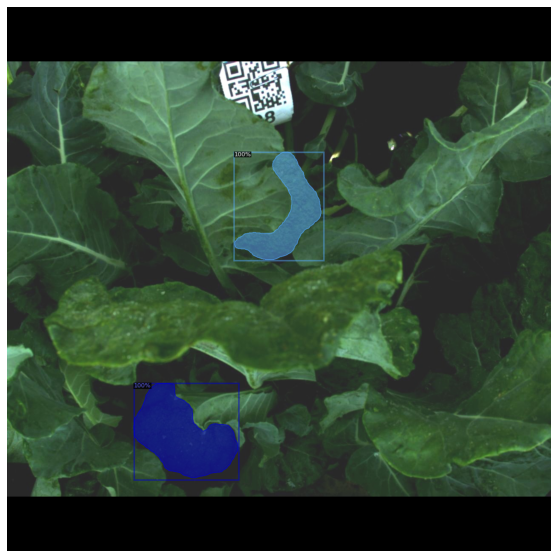

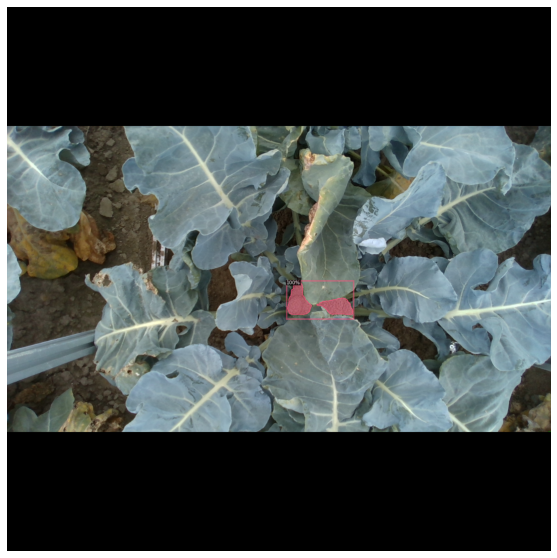

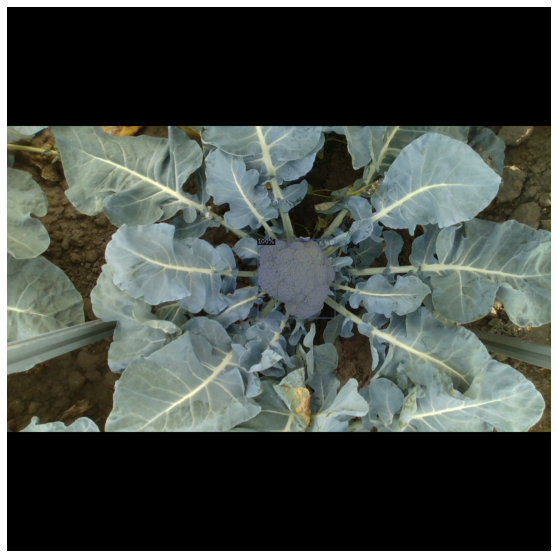

In [13]:
## visualize the visible mask output
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_visible_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(vis.get_image()[:, :, ::-1])

In [14]:
#  evaluate its performance using AP metric implemented in COCO API.
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("broccoli_visible_test", cfg, False, output_dir="results/20201010_broccoli_visible")
val_loader = build_detection_test_loader(cfg, "broccoli_visible_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[10/11 10:39:53 d2.data.datasets.coco]: Loaded 487 images in COCO format from datasets/train_val_test_files/mrcnn/mrcnn_only_visible/test/annotations.json
[10/11 10:39:53 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  broccoli  | 637          |
|            |              |
[10/11 10:39:53 d2.evaluation.evaluator]: Start inference on 487 images
[10/11 10:39:55 d2.evaluation.evaluator]: Inference done 11/487. 0.1102 s / img. ETA=0:00:56
[10/11 10:40:00 d2.evaluation.evaluator]: Inference done 55/487. 0.1082 s / img. ETA=0:00:49
[10/11 10:40:05 d2.evaluation.evaluator]: Inference done 100/487. 0.1081 s / img. ETA=0:00:44
[10/11 10:40:10 d2.evaluation.evaluator]: Inference done 144/487. 0.1084 s / img. ETA=0:00:39
[10/11 10:40:15 d2.evaluation.evaluator]: Inference done 187/487. 0.1096 s / img. ETA=0:00:34
[10/11 10:40:20 d2.evaluation.evaluator]: Inference done 229/487. 0.1103 s / img. ETA=0:00:30
[10/11 10

OrderedDict([('bbox',
              {'AP': 83.36428712379306,
               'AP50': 96.81593106981526,
               'AP75': 91.3589953337649,
               'APs': 16.531431714600032,
               'APm': 71.75489394428267,
               'APl': 89.07391843810612}),
             ('segm',
              {'AP': 85.91827444005511,
               'AP50': 96.9214285574046,
               'AP75': 94.8820164939903,
               'APs': 14.459599806134463,
               'APm': 73.50808205464782,
               'APl': 91.81988663134793})])